In [1]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 1.3 MB/s eta 0:00:02
   ------------- -------------------------- 0.5/1.4 MB 7.4 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.4 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 9.2 MB/s eta 0:00:00


In [3]:
# import relevant libraries
import itertools
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
import pandas as pd

# Load the files
attributes_df = pd.read_csv('attributes.csv', header=None)
edges_df = pd.read_csv('edges_train.edgelist', header=None)
solution_input_df = pd.read_csv('solutionInput.csv', header=None)

# Display first few rows of each DataFrame to inspect their structure
print("Attributes DataFrame:")
print(attributes_df.head())

print("\nEdges DataFrame:")
print(edges_df.head())

print("\nSolution Input DataFrame:")
print(solution_input_df.head())

# Clean the data by removing any headers (if necessary)
attributes_df_cleaned = attributes_df.drop(0)
solution_input_df_cleaned = solution_input_df.drop(0)

# Rename the columns to something meaningful
attributes_df_cleaned.columns = ['Node', 'Attribute']
solution_input_df_cleaned.columns = ['ID', 'Node1', 'Node2']

# Convert the node IDs to integers
attributes_df_cleaned['Node'] = attributes_df_cleaned['Node'].astype(int)
solution_input_df_cleaned['Node1'] = solution_input_df_cleaned['Node1'].astype(int)
solution_input_df_cleaned['Node2'] = solution_input_df_cleaned['Node2'].astype(int)

# Display the cleaned data
print("\nCleaned Attributes DataFrame:")
print(attributes_df_cleaned.head())

print("\nCleaned Solution Input DataFrame:")
print(solution_input_df_cleaned.head())


Attributes DataFrame:
    0          1
0  ID  attribute
1   0          l
2   1          x
3   2          x
4   3          x

Edges DataFrame:
   0  1
0  0  5
1  0  6
2  0  7
3  0  8
4  0  9

Solution Input DataFrame:
    0     1     2
0  ID  int1  int2
1   0    56   396
2   1   760   853
3   2   340  1137
4   3   597   771

Cleaned Attributes DataFrame:
   Node Attribute
1     0         l
2     1         x
3     2         x
4     3         x
5     4         x

Cleaned Solution Input DataFrame:
  ID  Node1  Node2
1  0     56    396
2  1    760    853
3  2    340   1137
4  3    597    771
5  4   1355   1410


In [7]:
import networkx as nx

# Create an undirected graph
graph = nx.Graph()

# Add edges from the edges_train.edgelist
graph.add_edges_from(edges_df.values)

# Print some basic information about the graph
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

# Check if the graph is connected
print(f"Is the graph connected? {nx.is_connected(graph)}")

# Example of getting neighbors of a node (optional, just to check)
node_id = 0  # Example node
print(f"Neighbors of node {node_id}: {list(graph.neighbors(node_id))}")


Number of nodes: 1500
Number of edges: 6600
Is the graph connected? True
Neighbors of node 0: [5, 6, 7, 8, 9, 12, 13, 14, 16, 17, 18, 21, 22, 23, 26, 34, 35, 40, 48, 55, 57, 63, 71, 81, 103, 113, 115, 118, 120, 124, 130, 161, 162, 173, 177, 178, 179, 204, 213, 232, 239, 242, 247, 112, 218, 76, 102, 323]


In [31]:
# Function to calculate features for each pair of nodes
def calculate_features(graph, node_pairs, attributes_df):
    features = []
    
    # Create a dictionary of attributes for quick lookup
    node_attributes = dict(zip(attributes_df['Node'], attributes_df['Attribute']))
    
    # Iterate over the node pairs
    for _, row in node_pairs.iterrows():
        node1 = row['Node1']
        node2 = row['Node2']
        
        # Common neighbors
        common_neighbors = len(list(nx.common_neighbors(graph, node1, node2)))
        
        # Jaccard coefficient
        jaccard_coeff = next(nx.jaccard_coefficient(graph, [(node1, node2)]), (None, None, 0))[2]
        
        # Adamic/Adar index
        adamic_adar = next(nx.adamic_adar_index(graph, [(node1, node2)]), (None, None, 0))[2]
        
        # Preferential attachment
        #preferential_attachment = next(nx.preferential_attachment(graph, [(node1, node2)]), (None, None, 0))[2]
        
        # Attribute similarity (1 if both nodes have the same attribute, 0 otherwise)
        attribute_similarity = 1 if node_attributes.get(node1) == node_attributes.get(node2) else 0
        
        # Append the calculated features for this pair of nodes
        features.append([common_neighbors, jaccard_coeff, adamic_adar, attribute_similarity])
    
    return pd.DataFrame(features, columns=['Common_Neighbors', 'Jaccard_Coeff', 'Adamic_Adar', 'Attr_Similarity'])

# Extract features for the node pairs in solutionInput.csv
solution_features = calculate_features(graph, solution_input_df_cleaned, attributes_df_cleaned)

# Display the extracted features
print(solution_features.head())


   Common_Neighbors  Jaccard_Coeff  Adamic_Adar  Attr_Similarity
0                 0        0.00000     0.000000                0
1                 2        0.04878     0.809981                1
2                 0        0.00000     0.000000                0
3                 0        0.00000     0.000000                0
4                 0        0.00000     0.000000                1


Validation Accuracy: 0.8333333333333334
Validation Precision: 0.8209285187914517


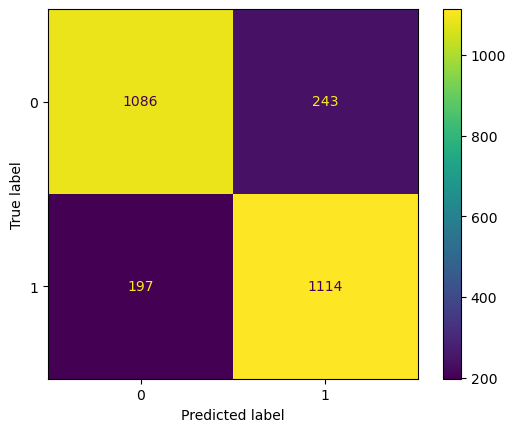

Sensitivity: 0.8497330282227308
Specificity: 0.8171557562076749
False positive rate: 0.18284424379232506
False negative rate: 0.15026697177726925
Precision: 0.8209285187914517


In [35]:
from sklearn.metrics import accuracy_score, precision_score
import numpy as np

# Step 4.1: Generate positive examples (existing edges)
positive_edges_df = pd.DataFrame(edges_df.values, columns=['Node1', 'Node2'])

# Step 4.2: Generate negative examples (random non-edges)
# We'll sample random pairs of nodes that are not connected
all_possible_edges = pd.DataFrame([(i, j) for i in range(graph.number_of_nodes()) for j in range(i+1, graph.number_of_nodes())])
existing_edges_set = set(map(tuple, map(sorted, edges_df.values)))

# Filter out existing edges to create negative samples
negative_edges_df = all_possible_edges[~all_possible_edges.apply(lambda x: tuple(sorted(x)) in existing_edges_set, axis=1)]
negative_edges_df = negative_edges_df.sample(n=1*len(positive_edges_df), random_state=42)  # Sample more negative examples (3:1 ratio)

# Step 4.3: Extract features for both positive and negative examples
positive_features = calculate_features(graph, positive_edges_df, attributes_df_cleaned)
negative_features = calculate_features(graph, negative_edges_df.rename(columns={0: 'Node1', 1: 'Node2'}), attributes_df_cleaned)

# Step 4.4: Assign labels (1 for positive, 0 for negative)
positive_features['Label'] = 1
negative_features['Label'] = 0

# Combine both into one dataset
training_data = pd.concat([positive_features, negative_features])

# Step 4.5: Separate features (X) and labels (y)
X = training_data.drop(columns=['Label'])
y = training_data['Label']

# Step 4.6: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4.7: Train a RandomForest classifier (or LGBM in this case)
# Parameter grids for each model
param_grid = [#{'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}]  # Logistic Regression
            {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10]}]  # RandomForest
    
model = RandomForestClassifier(random_state=42)
classifier = GridSearchCV(model, param_grid, cv=5)
#classifier = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, max_depth=5, n_estimators=50, num_leaves=20, random_state=42)
classifier.fit(X_train, y_train)

# Step 4.8: Predict on the validation set and calculate accuracy and precision
y_pred = classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
val_precision = precision_score(y_val, y_pred)

# Output the validation accuracy, precision, variance, and standard deviation
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")

cm = confusion_matrix(y_val, y_pred, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier.classes_)
disp.plot()
plt.show()

tp = cm[1][1]
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]

# Sensitivity (True positive rate) = TP/(TP+FN)
sensitivity = tp/(tp+fn)
# Specificity (True negative rate) = TN/(TN+FP)
specificity = tn/(tn+fp)
# False Positive Rate = FP/(FP+TN)
fpr = fp/(fp+tn)
# False Negative rate = FN/(FN+TP)
fnr = fn/(fn+tp)
# Precision = TP/(TP+FP)
precision = tp/(tp+fp)

print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('False positive rate:', fpr)
print('False negative rate:', fnr)
print('Precision:', precision)

In [37]:
# Step 5.1: Use the trained classifier to predict on the test set (solutionInput.csv)
# The features for the test set (solution_input_df_cleaned) have already been extracted as 'solution_features'
test_predictions = classifier.predict(solution_features)

# Step 5.2: Add the predictions to the solution input DataFrame
solution_input_df_cleaned['Prediction'] = test_predictions

# Step 5.3: Prepare the final output DataFrame (only ID and Prediction columns)
final_output = solution_input_df_cleaned[['ID', 'Prediction']]

# Step 5.4: Save the final output to a CSV file
final_output.to_csv('predictions_output.csv', index=False)

# Confirm completion
print("Predictions saved to 'predictions_output.csv'")


Predictions saved to 'predictions_output.csv'
